## Import dataframe

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# df = pd.read_json("train_AddToPlaylist_full.json")
df = pd.read_csv("intent_recognition_nigerian_varied_expanded.csv") 

In [3]:
new_df = df.head(500)

In [4]:
selected_new_df = new_df[["text-en", "intent-en"]]

In [47]:
selected_new_df[selected_new_df["intent-en"] == "getRecommendations"]

,text-en,intent-en
110,What items do you think I should try?,getRecommendations
111,Give me some suggestions based on my preferences,getRecommendations
112,What products should I check out?,getRecommendations
113,I’m looking for recommendations,getRecommendations
114,What would you suggest based on my past purcha...,getRecommendations
115,Suggest something for me,getRecommendations
116,Give me some suggestions based on my preferences,getRecommendations
117,Can you recommend items for me?,getRecommendations
118,Give me some suggestions based on my preferences,getRecommendations
119,Can I get some product recommendations?,getRecommendations


In [6]:
# selected_new_df[selected_new_df["intent-en"] == "makeReservation"]["text-en"][7]

## Data preparation (Train Test split)

In [7]:
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split

In [8]:
TEST_SPLIT = 0.2
RANDOM_STATE = 10

np.random.seed(RANDOM_STATE)
tf.random.set_seed(RANDOM_STATE)

In [9]:
X_train, X_test, y_train, y_test = train_test_split(df["text-en"], df["intent-en"], 
                                                    test_size = TEST_SPLIT, random_state = RANDOM_STATE, stratify=df["intent-en"])

# stratify was added to ensure equal category split

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(112,) (28,) (112,) (28,)


In [10]:
import numpy as np
print(np.unique(y_test))

['accessStores' 'addToCart' 'cancelReservation' 'contactSupport'
 'getRecommendations' 'getStoreDetails' 'makeReservation' 'purchase'
 'removeFromCart' 'searchProduct' 'trackOrder' 'updateProfile' 'viewCart'
 'viewStoreProducts']


In [11]:
print(np.unique(y_train))

['accessStores' 'addToCart' 'cancelReservation' 'contactSupport'
 'getRecommendations' 'getStoreDetails' 'makeReservation' 'purchase'
 'removeFromCart' 'searchProduct' 'trackOrder' 'updateProfile' 'viewCart'
 'viewStoreProducts']


## Data preparation (Input data (X_train and X_test) preparation for machine learning model)

In [12]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [13]:
# initialize tokenizer
# addition of out of vocabulary token to handle unseen words outside of the training dDeprecationWarning
# read more on the purpose of oov by looking up 
tokenizer = Tokenizer(oov_token="<UNK>")

## Summary: fit_on_texts creates a vocabulary (word index) based on the training data.

## Longer description:
# Fit the tokenizer on the training texts
# This method scans all the texts in X_train, finds all unique words,
# and assigns each word a unique index based on its frequency.
# More frequent words get lower index numbers.
# This prepares the tokenizer to convert text into sequences of integers.

# Note: Index in this case are numbers
tokenizer.fit_on_texts(list(X_train))

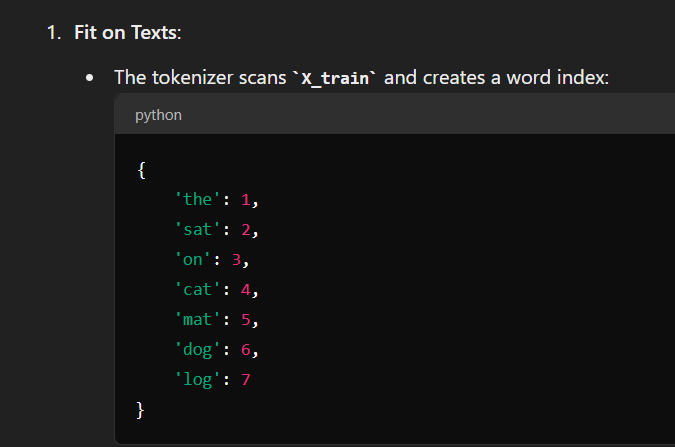

In [14]:
#Convert text to sequences
# texts_to_sequences uses this vocabulary to ensure that the same words are always converted to the same indices.
X_seq = tokenizer.texts_to_sequences(list(X_train))
X_test_seq = tokenizer.texts_to_sequences(list(X_test))

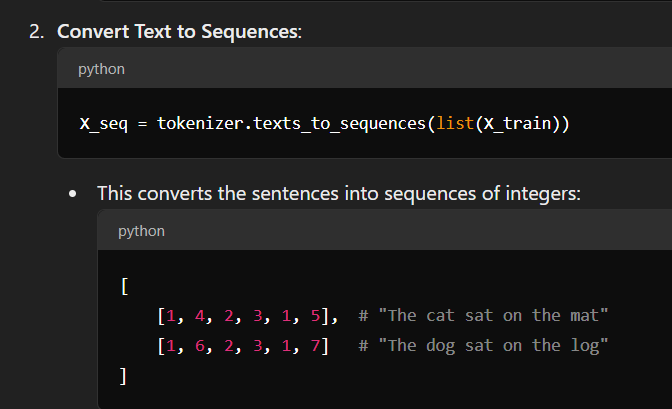

In [15]:
MAX_SEQ_LEN = 35

#Pad the sequences to ensure all sequences have the same length since neural networks 
# expect input sequences to have the same length
# This can be done either at the beginning (pre) or at the end (post) of the sequences.

# pad_sequences adjusts all sequences to the same length (MAX_SEQ_LEN).
# maxlen=MAX_SEQ_LEN specifies the desired length of the sequences.
# padding='post' specifies that padding should be added at the end of the sequences.

X_train = pad_sequences(X_seq, maxlen = MAX_SEQ_LEN, padding = 'post')
X_test = pad_sequences(X_test_seq, maxlen = MAX_SEQ_LEN, padding = 'post')

print(X_train.shape, X_test.shape)

(112, 35) (28, 35)


## Data preparation (Output data (y_train and y_test) preparation for machine learning model)  
#### Convert y labels into labels then one hot encoded values  
Why These Steps Are Necessary:   
Label Encoding: Machine learning algorithms, particularly neural networks, do not understand categorical labels directly. Label encoding converts these labels into a numerical format.  

One-Hot Encoding: For classification tasks, especially in multi-class classification, models often perform better when the labels are one-hot encoded. This format makes it easier for the model to output probabilities for each class and compute the loss correctly.

In [16]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras import utils


In [17]:
#Convert labels to one-hot vectors
y_train = y_train.to_numpy()
encoder = LabelEncoder()

# This line fits the LabelEncoder on the label data. 
# It learns all the unique categories (labels) and assigns each category a unique integer.
encoder.fit(y_train)

LabelEncoder()

In [18]:
# This line transforms the original categorical labels into their corresponding integer representations using the fitted LabelEncoder.
encoded_y_train = encoder.transform(y_train)

# converts the integer-encoded labels into a one-hot encoded format.
y_train_encoded = utils.to_categorical(encoded_y_train)

In [19]:
y_test = y_test.to_numpy()
encoded_y_test = encoder.transform(y_test)
y_test_encoded = utils.to_categorical(encoded_y_test)

In [20]:
print(y_train_encoded.shape, y_test_encoded.shape)

(112, 14) (28, 14)


## Set up for the Sequence Model    
Exmaples of sequence models are Recurrent Neural Network and Transformers.   
For this task we will use an architecture related to RNN called LSTM Long short term memory since text is sequential data  
https://medium.com/holler-developers/intent-detection-using-sequence-models-ddae9cd861ee  


### Steps    
Define a tensorflow Keras sequential model and add layers to it
- First layer will be the Embedding layer: used to represent each word with a vector of fixed length 16
- Second layer will be the LSTM layer with 16 units with a relu activation.
- Final layer will be the Dense layer(Output layer) with 7 units with a  softmax activation due to multi-classification
- Compile the model with adam optimizer, categorical crtoss entropy loss and evaluate performance metrics (precision, recall and accuracy)

In [21]:
VAL_SPLIT = 0.1
BATCH_SIZE = 32
EPOCHS = 80
EMBEDDING_DIM = 16
NUM_UNITS = 16
NUM_CLASSES = len(selected_new_df["intent-en"].unique())
VOCAB_SIZE = len(tokenizer.word_index) + 1

In [22]:
selected_new_df["intent-en"].unique()

array(['addToCart', 'removeFromCart', 'viewCart', 'purchase',
       'makeReservation', 'cancelReservation', 'accessStores',
       'searchProduct', 'viewStoreProducts', 'trackOrder',
       'getStoreDetails', 'getRecommendations', 'updateProfile',
       'contactSupport'], dtype=object)

In [23]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense
from tensorflow.keras.metrics import Precision, Recall

In [24]:
## Define a LSTM model  
lstm_model = Sequential()  

## Add layers  
# this converts the data into vectors which the algorithm understands
lstm_model.add(Embedding(input_dim=VOCAB_SIZE, output_dim=EMBEDDING_DIM, input_length=MAX_SEQ_LEN, mask_zero=True))

# Captures temporal dependencies in the sequence, understanding the context and order of words.
lstm_model.add(LSTM(NUM_UNITS, activation="relu"))  

# Maps the LSTM output to the number of classes, producing a probability distribution over possible intents
lstm_model.add(Dense(NUM_CLASSES, activation="softmax"))

In [25]:
## Compile model  
lstm_model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=[Precision(), Recall(), "accuracy"])
print(lstm_model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 35, 16)            2912      
                                                                 
 lstm (LSTM)                 (None, 16)                2112      
                                                                 
 dense (Dense)               (None, 14)                238       
                                                                 
Total params: 5262 (20.55 KB)
Trainable params: 5262 (20.55 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


## Training the Sequence Model(LSTM model)    
During the training ensure to look our for either an increase or decrease in precision, recall and accuracy.  
An increase in precision and recall means the model is imporving in both identifying relevant instances(recall) and minimizing false positives(precision).  
  
Note: At some point stabilization at high values should occur.

- Precision: The ratio of true positive predictions to the total number of positive predictions made by the model.   
It measures the accuracy of the positive predictions.  

- Recall: The ratio of true positive predictions to the total number of actual positive cases.   
It measures the model's ability to capture all positive instances.

In [26]:
lstm_history = lstm_model.fit(X_train, y_train_encoded, batch_size=BATCH_SIZE, epochs=EPOCHS, verbose=1, validation_split=VAL_SPLIT)

Epoch 1/80
4/4 [==============================] - 2s 151ms/step - loss: 2.6391 - precision: 0.0000e+00 - recall: 0.0000e+00 - accuracy: 0.0400 - val_loss: 2.6376 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_accuracy: 0.0833
Epoch 2/80
4/4 [==============================] - 0s 22ms/step - loss: 2.6363 - precision: 0.0000e+00 - recall: 0.0000e+00 - accuracy: 0.0500 - val_loss: 2.6369 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_accuracy: 0.0833
Epoch 3/80
4/4 [==============================] - 0s 22ms/step - loss: 2.6339 - precision: 0.0000e+00 - recall: 0.0000e+00 - accuracy: 0.1500 - val_loss: 2.6366 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_accuracy: 0.1667
Epoch 4/80
4/4 [==============================] - 0s 23ms/step - loss: 2.6317 - precision: 0.0000e+00 - recall: 0.0000e+00 - accuracy: 0.1600 - val_loss: 2.6355 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_accuracy: 0.1667
Epoch 5/80
4/4 [==============================] - 0

## Model Evaluation

In [27]:
lstm_score = lstm_model.evaluate(X_test, y_test_encoded, batch_size=BATCH_SIZE, verbose=1)

1/1 [==============================] - 0s 29ms/step - loss: 8.9647 - precision: 0.7308 - recall: 0.6786 - accuracy: 0.6786


## Analysis  
With an Epoch of 30 it seems like the model performed better i.e giving the model more training time it performed better   

### High Precision and High Accuracy:   
These indicate that your model is very accurate in its predictions overall and particularly effective at making correct positive predictions.
Good but Not Perfect Recall: While 0.89 recall is high, it shows that the model misses 11% of the actual positive instances.

In [28]:
from sklearn import metrics  

In [29]:
y_pred_labels_lstm = [encoder.classes_[x] for x in np.argmax(lstm_model.predict(X_test), axis=-1)]
print(metrics.classification_report(y_test, y_pred_labels_lstm))

1/1 [==============================] - 0s 209ms/step
                    precision    recall  f1-score   support

      accessStores       1.00      0.50      0.67         2
         addToCart       0.67      1.00      0.80         2
 cancelReservation       1.00      1.00      1.00         2
    contactSupport       1.00      0.50      0.67         2
getRecommendations       1.00      0.50      0.67         2
   getStoreDetails       1.00      0.50      0.67         2
   makeReservation       1.00      0.50      0.67         2
          purchase       0.00      0.00      0.00         2
    removeFromCart       0.50      0.50      0.50         2
     searchProduct       0.67      1.00      0.80         2
        trackOrder       0.50      1.00      0.67         2
     updateProfile       0.67      1.00      0.80         2
          viewCart       1.00      1.00      1.00         2
 viewStoreProducts       0.25      0.50      0.33         2

          accuracy                           

C:\Users\mikos\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mikos\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mikos\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1471

## Using the model

In [31]:
# sentence = "I am travelling fresnosoon how do I let people know"
# sentence = "how do i whisper"

sentence = "Help me find me Ankara dress"
input_seq = tokenizer.texts_to_sequences([sentence])
input_features = pad_sequences(input_seq, maxlen = MAX_SEQ_LEN, padding = 'post')

In [51]:
#Predict the label
probs = lstm_model.predict(input_features)
predicted_y = probs.argmax(axis=-1)
print(encoder.classes_[predicted_y][0])

1/1 [==============================] - 0s 33ms/step
getRecommendations


In [56]:
# sentence = "I am travelling fresnosoon how do I let people know"
# sentence = "how do i whisper"
sentence = "Tell me about lagos essentials"
input_seq = tokenizer.texts_to_sequences([sentence])
input_features = pad_sequences(input_seq, maxlen = MAX_SEQ_LEN, padding = 'post')

In [50]:
# sentence = "I am travelling fresnosoon how do I let people know"
# sentence = "how do i whisper"

sentence = "any suggestions?"
input_seq = tokenizer.texts_to_sequences([sentence])
input_features = pad_sequences(input_seq, maxlen = MAX_SEQ_LEN, padding = 'post')

In [ ]:
# def make_reservation(fname, lname):
#   print("reservation made for "+ fname + " " + lname)

In [ ]:
# if encoder.classes_[predicted_y][0] == "restaurant_reservation":
#     make_reservation("Michael", "Osuntuyi")




### Exporting model for use in Web Application  
This was exported using tensorflow savedmodel rather than HDF5 format due to tensorflow having the ability to be used in C# and Java

In [52]:
lstm_model.save('intent_recognition_model') 

INFO:tensorflow:Assets written to: intent_recognition_model\assets


INFO:tensorflow:Assets written to: intent_recognition_model\assets


### Load and test model

In [53]:
from tensorflow.keras.models import load_model

In [54]:
model = load_model('intent_recognition_model') 

In [57]:
probs2 = model.predict(input_features)

predicted_y2 = probs2.argmax(axis=-1)
print(encoder.classes_[predicted_y2][0])

1/1 [==============================] - 0s 36ms/step
getStoreDetails
